<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objective" data-toc-modified-id="Objective-1">Objective</a></span></li><li><span><a href="#About-Food-101" data-toc-modified-id="About-Food-101-2">About Food-101</a></span></li><li><span><a href="#Train-valid-split" data-toc-modified-id="Train-valid-split-3">Train-valid-split</a></span></li><li><span><a href="#Load-Food-101-Dataset" data-toc-modified-id="Load-Food-101-Dataset-4">Load Food-101 Dataset</a></span></li><li><span><a href="#Data-Augmentation" data-toc-modified-id="Data-Augmentation-5">Data Augmentation</a></span></li><li><span><a href="#Baseline-Resnet-50" data-toc-modified-id="Baseline-Resnet-50-6">Baseline Resnet-50</a></span><ul class="toc-item"><li><span><a href="#Finding-a-Good-Learning-Rate" data-toc-modified-id="Finding-a-Good-Learning-Rate-6.1">Finding a Good Learning Rate</a></span></li><li><span><a href="#Training-with-Progressive-Resizing" data-toc-modified-id="Training-with-Progressive-Resizing-6.2">Training with Progressive Resizing</a></span></li><li><span><a href="#Test-Time-Augmentation" data-toc-modified-id="Test-Time-Augmentation-6.3">Test Time Augmentation</a></span></li><li><span><a href="#Post-mortem" data-toc-modified-id="Post-mortem-6.4">Post-mortem</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-7">Conclusion</a></span></li></ul></div>

In [3]:
import numpy as np
import torch

from pathlib import Path
from fastai2.vision.all import *
from fastai2.vision.widgets import *

In [4]:
# Set seed for reproducibility
seed = 9
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:
# Although we don't condone it, let's silence warnings for the sake of readability
import warnings
warnings.filterwarnings("ignore")

---------

# Objective

The goal of this notebook is to train an image classifier on the full [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101) using the `fastai2` library. We'll be implementing the progressize resizing strategy developed in the prototype notebook `MS-food-101-tiny-fastai2.ipynb`, which experimented with a small subset of the Food-101 dataset consisting of ten classes with 150 training and 50 validation images per class. This model will serve as our baseline. In separate notebooks, we'll try adding label smoothing and MixUp to see if we can't do a little better.

--------

# About Food-101

The [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) consists of 101 classes of food, with $750$ training images and $250$ validation images in each class, for a total of $75,750$ training images and $25,250$ validation images. Classes include foods like `apple pie, bibimbap, crab cakes, gyoza, nachos, and pho`.

All images have been rescaled to have a maximum side length of $512$ pixels and training images have been deliberately left uncleaned (mostly in the form of intense colours and occassionally incorrect labels, according to the authors of the [original paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)). Examining a few images from a handful of classes, we find that $512$ x $384$ (or the transpose) is a common image size. We also find that a non-trivial amount of labels are shockingly incorrect. For example, one of the images labeled "french toast" is an image of an omelette.

-----

# Train-valid-split

We've split the `Food-101` dataset beforehand into Imagenet-style `train/` and `valid/` folders following the `train.txt` and `test.txt` files provided in the dataset's `meta/` directory. This makes loading the data easier as with fastai.

--------

# Load Food-101 Dataset

Let's load and prep our dataset for modeling.

In [6]:
# Prep DataBlock with item & batch transforms
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                  get_items=get_image_files,
                  get_y=parent_label,
                  splitter=GrandparentSplitter(),
                  item_tfms=Resize(460),
                  batch_tfms=aug_transforms(size=224, min_scale=0.75))

# Load data
path = Path("../input/food101split/data/food-101-split")
dls = dblock.dataloaders(path, bs=64)

In [7]:
# Verify number of classes and images
print(dls.train.c, dls.train.n) 
print(dls.valid.c, dls.valid.n)

101 75750
101 25250


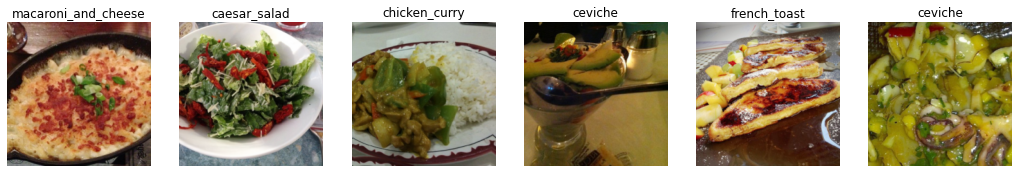

In [8]:
# Inspect data. Yum! Looks good to me!
dls.show_batch(nrows=1, ncols=6)

# Data Augmentation

When we initalised our `DataBlock` above, we had to specify what types of transforms we wanted to use to augument our data. We used the standard transforms specified in `aug_transforms`. By specifying `min_scale=0.75`, we also enabled `RandomResizeCrop`, which is performed on the fly on each batch on the gpu (hence won't be shown below). Let's take a closer look at these transforms before we move on. 

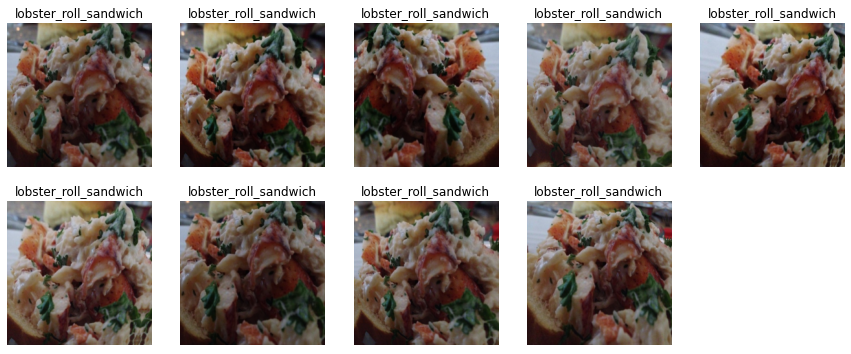

In [9]:
# Original plus eight augmentations for brightness/contrast, rotation, and a flip about x=0
dls.show_batch(nrows=2, unique=True)

---------

# Baseline Resnet-50

Because we witnessed such tremendous gains in performance on our curated `Food-101-tiny` dataset using `resnet-50` and progressive resizing, we'll start there. We'll use `Top-1` accuracy as our validation metric throughout. Note that `cnn_learner` automatically normalizes its data using the stats of the pre-trained model (which will be `ImageNet` stats in our case).

## Finding a Good Learning Rate

Let's start with finding a good base learning rate.

In [ ]:
# First find a good base learning rate 
learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.lr_find()

Looks like the steepest slope is around `6e-3`.

## Training with Progressive Resizing

Progressive resizing is the process of gradually using larger and larger images as you train. The key insight behind progressive resizing is the idea that the kinds of features CNNs learn aren't specific to the size of the images it sees. By initially training on smaller images, epochs complete much faster. Finishing training on larger images makes the final accuracy much higher. Progresive resizing also functions as another form of data augmentation and so should help a model generalize.

To implement progressive resizing, we'll define a helper function that returns a set of dataloaders with images of a specified size.

In [10]:
def get_dls(path, bs, size):
    """Return a set of train and valid dataloaders with images of a given size."""
    dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                  get_items=get_image_files,
                  get_y=parent_label,
                  splitter=GrandparentSplitter(),
                  item_tfms=Resize(512),
                  batch_tfms=aug_transforms(size=size, min_scale=0.75))
    return dblock.dataloaders(path, bs=bs)

In [11]:
# Start with image size 224
learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.dls = get_dls(path, bs=64, size=224)
learn.fine_tune(6, 6e-3, freeze_epochs=2)
learn.save("kaggle-resnet50-224")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,time
0,2.044829,1.415945,0.618178,15:52
1,1.681749,1.106521,0.695802,14:54


epoch,train_loss,valid_loss,accuracy,time
0,1.441414,1.004469,0.725624,15:34
1,1.321581,0.987686,0.727168,15:36
2,1.121678,0.749058,0.786772,15:34
3,0.861629,0.604747,0.831683,15:41
4,0.624346,0.504579,0.858099,15:30
5,0.504620,0.484958,0.864079,15:29


In [ ]:
# Bump to max image dim in our dataset
learn.dls = get_dls(path, bs=24, size=512)
learn.fine_tune(7, 1e-3)
learn.save("kaggle-resnet50-224-512")

epoch,train_loss,valid_loss,accuracy,time
0,0.741622,0.534500,0.850218,37:38
1,0.740405,0.494173,0.860158,37:41
2,0.627647,0.501337,0.858099,37:42
3,0.568926,0.465310,0.868713,37:31
4,0. 497316,0.440169,0.879010,37:30
5,0.426951,0.425248,0.883248,37:39
6,0.387782,0.428303,0.882059,37:35


## Test Time Augmentation

The last thing we can do to squeeze out a bit of performance is use test time augmentation. We'll use fastai's default `tta()` method, which takes a weighted average of the model's prediction with the predictions from `n=4` augmented images. Because some of the categories in `Food-101` are so similar to one another (e.g. `steak`, `filet mignon`, `porkchop`), we're also curious how our model performs given two guesses for each image. 

In [ ]:
preds, targets = learn.tta(n=4)
top_1 = accuracy(preds, targets).item()
top_2 = top_k_accuracy(preds, targets, k=2).item()
print(f"Top-1 Accuracy: {top_1: .4f} | Top-2 Accuracy {top_2: .4f}")

Top-1 Accuracy:  0.8964 | Top-2 Accuracy  0.9497


Wow! We're seeing a huge boost in performance when our model gets an extra guess. This suggests that our model is nearly on the money every time and is confused between similar classes. Let's dig into our model's predictions and see if that's the case.

## Post-mortem

Let's take a closer look at which classes our model had a hard time with.

In [ ]:
# Sadly, this keeps crashing the notebook (OOM error)
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=5)

------------

# Conclusion

We've successfully trained a baseline `resnet50` model on the `Food-101` dataset with progressive re-sizing, coming close to matching [state-of-the-art](https://platform.ai/blog/page/3/new-food-101-sota-with-fastai-and-platform-ais-fast-augmentation-search/) on this task, which was a `Top-1` accuracy of `90.52` as of February, 2019. 

The dramatic difference between `Top-1` and `Top-2` accuracy for our model suggests that it struggles with similar classes like `steak`, `pork chop`, and `filet mignon` (which would be difficult for even a human to reliably distinguish between). Unfortunately, we weren't able to take a closer look as our kernel kept crashing when trying to inspect our model's performance on each class in greater detail.